In [1]:

import itertools

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn.init as init
from torch import nn
from torch import distributions
from torch.distributions import MultivariateNormal, Uniform, TransformedDistribution, SigmoidTransform
from torch.nn.parameter import Parameter

from nflib.flows import (
    AffineConstantFlow, ActNorm, AffineHalfFlow, 
    SlowMAF, MAF, IAF, Invertible1x1Conv,
    NormalizingFlow, NormalizingFlowModel,
)
from nflib.spline_flows import NSF_AR, NSF_CL

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Будем работать с тем же датасетом Moons. Набросаем равномерным случайным образом аномалии

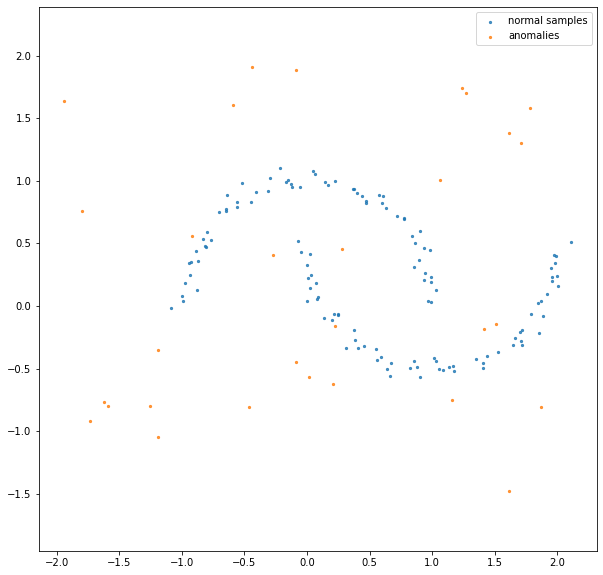

In [10]:
import pickle
from sklearn import datasets

class DatasetSIGGRAPH:
    """ 
    haha, found from Eric https://blog.evjang.com/2018/01/nf2.html
    https://github.com/ericjang/normalizing-flows-tutorial/blob/master/siggraph.pkl
    """
    def __init__(self):
        with open('siggraph.pkl', 'rb') as f:
            XY = np.array(pickle.load(f), dtype=np.float32)
            XY -= np.mean(XY, axis=0) # center
        self.XY = torch.from_numpy(XY)
    
    def sample(self, n):
        X = self.XY[np.random.randint(self.XY.shape[0], size=n)]
        return X

class DatasetMoons:
    """ two half-moons """
    def sample(self, n):
        moons = datasets.make_moons(n_samples=n, noise=0.05)[0].astype(np.float32)
        return torch.from_numpy(moons)

class DatasetMixture:
    """ 4 mixture of gaussians """
    def sample(self, n):
        assert n%4 == 0
        r = np.r_[np.random.randn(n // 4, 2)*0.5 + np.array([0, -2]),
                  np.random.randn(n // 4, 2)*0.5 + np.array([0, 0]),
                  np.random.randn(n // 4, 2)*0.5 + np.array([2, 2]),
                  np.random.randn(n // 4, 2)*0.5 + np.array([-2, 2])]
        return torch.from_numpy(r.astype(np.float32))

class DatasetAnomalies:
    def sample(self, n):
        return -2 + 4*torch.rand((n,2))

d = DatasetMoons()
a = DatasetAnomalies()
#d = DatasetMixture()
#d = DatasetSIGGRAPH()

x = d.sample(128) # normal samples
x_an = a.sample(30) # anomalies
plt.figure(figsize=(10,10))
plt.scatter(x[:,0], x[:,1], s=5, alpha=0.8, label='normal samples')
plt.scatter(x_an[:,0], x_an[:,1], s=5, alpha=0.8, label='anomalies')
plt.legend()
plt.axis('equal');

In [11]:

# construct a model
#prior = MultivariateNormal(torch.zeros(2), torch.eye(2))
prior = TransformedDistribution(Uniform(torch.zeros(2), torch.ones(2)), SigmoidTransform().inv) # Logistic distribution

# RealNVP
# flows = [AffineHalfFlow(dim=2, parity=i%2) for i in range(9)]

# NICE
# flows = [AffineHalfFlow(dim=2, parity=i%2, scale=False) for i in range(4)]
# flows.append(AffineConstantFlow(dim=2, shift=False))

# SlowMAF (MAF, but without any parameter sharing for each dimension's scale/shift)
# flows = [SlowMAF(dim=2, parity=i%2) for i in range(4)]

# MAF (with MADE net, so we get very fast density estimation)
# flows = [MAF(dim=2, parity=i%2) for i in range(4)]

# IAF (with MADE net, so we get very fast sampling)
# flows = [IAF(dim=2, parity=i%2) for i in range(3)]

# insert ActNorms to any of the flows above
# norms = [ActNorm(dim=2) for _ in flows]
# flows = list(itertools.chain(*zip(norms, flows)))

# Glow paper
# flows = [Invertible1x1Conv(dim=2) for i in range(3)]
# norms = [ActNorm(dim=2) for _ in flows]
# couplings = [AffineHalfFlow(dim=2, parity=i%2, nh=32) for i in range(len(flows))]
# flows = list(itertools.chain(*zip(norms, flows, couplings))) # append a coupling layer after each 1x1

# Neural splines, coupling
nfs_flow = NSF_CL if True else NSF_AR
flows = [nfs_flow(dim=2, K=8, B=3, hidden_dim=16) for _ in range(3)]
convs = [Invertible1x1Conv(dim=2) for _ in flows]
norms = [ActNorm(dim=2) for _ in flows]
flows = list(itertools.chain(*zip(norms, convs, flows)))

# construct the model
model = NormalizingFlowModel(prior, flows)

In [12]:
# optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5) # todo tune WD
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  5844


Обучим модель

In [13]:
from tqdm.auto import tqdm
n_epoches = 1000
model.train()
pbar = tqdm(range(n_epoches), desc='Loss: ?')
for k in pbar:
    x = d.sample(128)
    
    zs, prior_logprob, log_det = model(x)
    logprob = prior_logprob + log_det
    loss = -torch.sum(logprob) # NLL

    model.zero_grad()
    loss.backward()
    optimizer.step()
    
    pbar.update(1)
    pbar.set_description(f'Loss: {loss.item():.2f}')
    pbar.refresh()
pbar.close()

Посмотрим на выученную плотность распределения

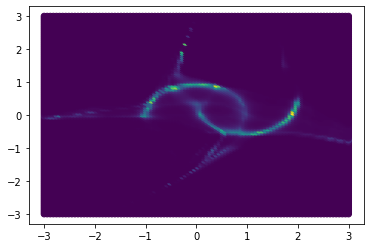

In [14]:
ng = 100
xx, yy = np.linspace(-3, 3, ng), np.linspace(-3, 3, ng)
xv, yv = np.meshgrid(xx, yy)
xy = np.stack([xv, yv], axis=-1)
xy = xy.reshape((ng*ng, 2))
xy = torch.from_numpy(xy).float()
zs, prior_logprob, log_det = model(xy)
plt.scatter(xy[:,0], xy[:,1], c=(prior_logprob+log_det).detach().exp())

**Задание 1**: Посмотрите, как отличается likelihood для нормальных объектов и аномалий (используйте гистограммы)

In [15]:
??? # Your code here

Object `? # Your code here` not found.


**Задание 2**: Посмотрите на ROC AUC (при соотношении аномалий к нормальным объектам 1:1)

In [ ]:
??? # Your code here

**Задание 3**

Реализуйте алгоритм поиска аномалий из статьи [WAIC, but Why?](https://arxiv.org/pdf/1810.01392.pdf)

Алгоритм предельно простой и представляет собой Watanabe-Akaike Information Criterion (WAIC), оцененный по ансамблю моделей:
$$WAIC(x)=\mathbb{E}_\theta\log p_\theta(x)-Var_\theta\log p_\theta(x)$$

In [16]:
??? # Your code here

Object `? # Your code here` not found.
